In [1]:
import pickle
import os
import numpy as np
from sklearn.cluster import KMeans, Birch
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import math
from sklearn.metrics import homogeneity_score
from scipy.stats import entropy
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse
os.chdir("../../..")
print(os.getcwd())

/Users/titonka/FAIRIS


In [2]:
# Function to plot clusters on the x, y plane
def plot_clusters(xy_list, cluster_labels, name):
    """
    Plot the clusters on the x, y plane using the original (x, y) coordinates, and save the figure.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - name (str): The filename to save the figure as (e.g., "clusters_plot.png").
    """
    # Convert xy_list to NumPy arrays for easy plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])

    # Check if the lengths match
    if len(x_coords) != len(cluster_labels):
        raise ValueError(f"Mismatch: {len(x_coords)} coordinates and {len(cluster_labels)} cluster labels.")

    # Scatter plot with color coding for clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x_coords, y_coords, c=cluster_labels, cmap='rainbow', alpha=0.7)

    # Add color bar to indicate clusters
    plt.colorbar(scatter, label='Cluster')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Clustering with {len(set(cluster_labels))} Clusters on X-Y Plane')

    # Save the plot to the specified file
    plt.savefig(name)

    # Close the plot to avoid displaying it when running in scripts
    plt.close()


def plot_clusters_by_subplots(xy_list, theta_list, cluster_labels, name, n_clusters=8):
    """
    Plot the clusters on subplots, one for each cluster, using the original (x, y) coordinates
    and their corresponding direction vectors.

    Args:
    - xy_list (list of tuples): The original x, y coordinates for each datapoint.
    - theta_list (list of floats): The orientation (theta) in degrees for each datapoint.
    - cluster_labels (list of int): The cluster label for each datapoint.
    - name (str): The filename to save the plot.
    - n_clusters (int): Number of clusters to plot.
    """
    # Fixed number of columns
    cols = 5
    # Calculate the number of rows needed
    rows = int(math.ceil(n_clusters / cols))

    # Dynamically scale the figsize based on rows and columns
    width_per_col = 6  # Adjust this for horizontal scaling
    height_per_row = 6  # Adjust this for vertical scaling
    figsize = (cols * width_per_col, rows * height_per_row)

    # Convert xy_list to NumPy arrays for easy filtering and plotting
    x_coords = np.array([x for x, y in xy_list])
    y_coords = np.array([y for x, y in xy_list])
    theta_list = np.array([theta for theta in theta_list])
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for cluster_id in range(n_clusters):
        # Get the indices of the datapoints that belong to the current cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0]

        # Filter x and y coordinates for the current cluster
        cluster_x = x_coords[cluster_indices]
        cluster_y = y_coords[cluster_indices]

        # Extract theta values for the current cluster
        cluster_theta = theta_list[cluster_indices]

        # Compute dx and dy for each point in the current cluster
        cluster_dx = 0.5 * np.cos(np.radians(cluster_theta))
        cluster_dy = 0.5 * np.sin(np.radians(cluster_theta))

        # Scatter plot for the current cluster
        axes[cluster_id].scatter(cluster_x, cluster_y, c=f'C{cluster_id}', alpha=0.7, label='Points')

        # Add quiver plot for vectors
        axes[cluster_id].quiver(cluster_x, cluster_y, cluster_dx, cluster_dy, angles='xy', scale_units='xy', scale=1,
                                color='black', alpha=0.7, label='Vectors')

        # Set subplot title and labels
        axes[cluster_id].set_title(f'Cluster {cluster_id}')
        axes[cluster_id].set_xlabel('X Coordinate')
        axes[cluster_id].set_ylabel('Y Coordinate')
        axes[cluster_id].set_xlim(-3, 3)  # Set x-axis limits
        axes[cluster_id].set_ylim(-3, 3)  # Set y-axis limits
        axes[cluster_id].legend()

    # Hide unused subplots (if n_clusters < len(axes))
    for i in range(n_clusters, len(axes)):
        axes[i].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot to the specified file
    fig.savefig(name)
    plt.close()

def format_data_for_clustering(data):
    multimodal_feature_vectors = []
    cnn_feature_vectors = []
    xy_list = []
    theta_list = []
    for observation in data.observations:
        multimodal_feature_vectors.append(observation.multimodal_feature_vector)
        cnn_feature_vectors.append(observation.cnn_feature_vector)
        xy_list.append((observation.x, observation.y))
        theta_list.append(observation.theta)

    return multimodal_feature_vectors, cnn_feature_vectors, xy_list, theta_list


def cluster_with_kmeans_and_save_centers(features_list, n_clusters, centers_save_path=None):
    """
    Perform KMeans clustering, calculate the maximum distance for each cluster,
    and save the cluster centers and max distances as a list of lists using pickle.

    Args:
    - features_list (list of numpy arrays): The feature vectors extracted from the images.
    - n_clusters (int): The number of clusters to form.
    - centers_save_path (str): Path to save the cluster centers and max distances using pickle.

    Returns:
    - cluster_labels (list of int): The cluster label for each datapoint.
    - cluster_centers (numpy array): The centers of the final clusters.
    """
    features_array = np.array(features_list)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_array)

    # Get cluster centers and labels for each data point
    cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # List to store [center, max_distance] for each cluster
    cluster_data = []

    # Calculate max distance for each cluster
    for cluster_index in range(n_clusters):
        # Get data points belonging to this cluster
        cluster_points = features_array[labels == cluster_index]

        # Calculate distances from each point to the cluster center
        distances = cdist(cluster_points, [cluster_centers[cluster_index]], metric='euclidean').flatten()

        # Find the maximum distance for this cluster
        max_distance = distances.max()

        # Append the center and max distance as a pair to cluster_data
        cluster_data.append([cluster_centers[cluster_index].tolist(), max_distance])

    # Save cluster_data (centers and max distances) using pickle
    if centers_save_path is not None:
        with open(centers_save_path, 'wb') as f:
            pickle.dump(cluster_data, f)

    return cluster_labels

# Dunn Index
def dunn_index(data, labels):

    # Ensure labels are NumPy arrays
    labels = np.array(labels)
    data = np.array(data)
    unique_labels = np.unique(labels)

    # Inter-cluster distances (minimum distance between clusters)
    inter_cluster_distances = []
    for i, label_a in enumerate(unique_labels):
        cluster_a = data[labels == label_a]
        for label_b in unique_labels[i + 1:]:
            cluster_b = data[labels == label_b]
            distances = pdist(np.vstack([cluster_a, cluster_b]))
            inter_cluster_distances.append(np.min(distances))
    min_inter_cluster_distance = min(inter_cluster_distances)

    # Intra-cluster distances (maximum distance within a cluster)
    intra_cluster_distances = []
    for label in unique_labels:
        cluster = data[labels == label]
        if len(cluster) > 1:  # Ensure at least two points in the cluster
            distances = pdist(cluster)
            intra_cluster_distances.append(np.max(distances))
    max_intra_cluster_distance = max(intra_cluster_distances)

    return min_inter_cluster_distance / max_intra_cluster_distance

# Within-Cluster Sum of Squares (WCSS)
def wcss(data, labels):
    wcss_value = 0
    for label in np.unique(labels):
        cluster = data[labels == label]
        centroid = np.mean(cluster, axis=0)
        wcss_value += np.sum((cluster - centroid) ** 2)
    return wcss_value

In [3]:
class ClusteringWithLabels:
    def __init__(self, multimodal_feature_vectors, cnn_feature_vectors, xy_list, theta_list,  multimodal_labels, cnn_labels):
        self.multimodal_feature_vectors = multimodal_feature_vectors
        self.cnn_feature_vectors = cnn_feature_vectors
        self.xy_list = xy_list
        self.theta_list = theta_list
        self.multimodal_labels = multimodal_labels
        self.cnn_labels = cnn_labels
        

In [4]:
with open("data/VisualPlaceCellData/LM8_Training",'rb') as file:
    visual_place_cell_data = pickle.load(file)

multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list = format_data_for_clustering(visual_place_cell_data)
n_clusters = [10,20,100,500]  # You can change this based on how many clusters you expect
# n_clusters = [10]
for n_cluster in n_clusters:    
    multimodal_labels = cluster_with_kmeans_and_save_centers(multimodal_feature_vectors, n_cluster)
    cnn_labels = cluster_with_kmeans_and_save_centers(cnn_feature_vectors,n_cluster)
    cluster_and_labels = ClusteringWithLabels(multimodal_feature_vectors,cnn_feature_vectors,xy_list,theta_list,multimodal_labels=multimodal_labels,cnn_labels=cnn_labels)
    save_path = "data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers"
    with open(save_path, 'wb') as f:
        pickle.dump(cluster_and_labels, f)

In [8]:
n_cluster = 500
with open("data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers",'rb') as file:
    cluster_data = pickle.load(file)
 # 1. Silhouette Score
silhouette = silhouette_score(cluster_data.multimodal_feature_vectors, cluster_data.multimodal_labels)
print(f"Silhouette Score: {silhouette}")

# 2. Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(cluster_data.multimodal_feature_vectors, cluster_data.multimodal_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

# 3. Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(cluster_data.multimodal_feature_vectors, cluster_data.multimodal_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")



# 1. Silhouette Score
silhouette = silhouette_score(cluster_data.cnn_feature_vectors, cluster_data.cnn_labels)
print(f"Silhouette Score: {silhouette}")

# 2. Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(cluster_data.cnn_feature_vectors, cluster_data.cnn_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")

# 3. Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(cluster_data.cnn_feature_vectors, cluster_data.cnn_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Silhouette Score: 0.1851815219440987
Davies-Bouldin Index: 1.5637580615491016
Calinski-Harabasz Index: 44.34271788729767
Silhouette Score: 0.09317619353532791
Davies-Bouldin Index: 2.2163476519668084
Calinski-Harabasz Index: 8.752073326248853


In [37]:
# Function to extract landmark masks dynamically
def extract_landmark_masks(clustering_instance, labels_type):
    if labels_type == 'multimodal':
        return np.array([vector[-10:-2] for vector in clustering_instance.multimodal_feature_vectors])
    elif labels_type == 'cnn':
        return np.array([vector[-10:-2] for vector in clustering_instance.multimodal_feature_vectors])
    else:
        raise ValueError("Invalid labels_type. Choose 'multimodal' or 'cnn'.")

# Function to calculate Cluster Purity
def calculate_cluster_purity(clustering_instance, labels_type='multimodal'):
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    landmark_masks = extract_landmark_masks(clustering_instance, labels_type)

    unique_clusters = np.unique(labels)
    total_points = len(labels)
    purity_sum = 0

    for cluster in unique_clusters:
        cluster_indices = labels == cluster
        masks_in_cluster = landmark_masks[cluster_indices]
        most_common = np.bincount(np.argmax(masks_in_cluster, axis=1)).max()
        purity_sum += most_common

    return purity_sum / total_points

# Function to calculate Average Cluster Entropy
def calculate_cluster_entropy(clustering_instance, labels_type='multimodal'):
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    landmark_masks = extract_landmark_masks(clustering_instance, labels_type)

    unique_clusters = np.unique(labels)
    entropy_sum = 0

    for cluster in unique_clusters:
        cluster_indices = labels == cluster
        masks_in_cluster = landmark_masks[cluster_indices]
        proportions = np.mean(masks_in_cluster, axis=0)
        entropy_sum += entropy(proportions)

    return entropy_sum / len(unique_clusters)

# Function to calculate Homogeneity Score
def calculate_homogeneity_score(clustering_instance, labels_type='multimodal'):
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    landmark_masks = extract_landmark_masks(clustering_instance, labels_type)
    majority_landmark_labels = np.argmax(landmark_masks, axis=1)
    return homogeneity_score(majority_landmark_labels, labels)

In [35]:
test = cluster_data.cnn_feature_vectors[500]

print(test[-10:-2])

[0. 0. 0. 0. 0. 0. 0. 0.]


In [41]:
n_cluster = 500
with open("data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers",'rb') as file:
    cluster_data = pickle.load(file)
    
# Calculate Cluster Purity
purity = calculate_cluster_purity(cluster_data, labels_type='multimodal')
print(f"Cluster Purity (Multimodal): {purity}")

# Calculate Homogeneity Score
homogeneity = calculate_homogeneity_score(cluster_data, labels_type='multimodal')
print(f"Homogeneity Score (Multimodal): {homogeneity}")

# Calculate Cluster Purity
purity = calculate_cluster_purity(cluster_data, labels_type='cnn')
print(f"Cluster Purity (CNN): {purity}")

# Calculate Homogeneity Score
homogeneity = calculate_homogeneity_score(cluster_data, labels_type='cnn')
print(f"Homogeneity Score (CNN): {homogeneity}")

Cluster Purity (Multimodal): 0.855078125
Homogeneity Score (Multimodal): 0.8040919137039501
Cluster Purity (CNN): 0.70078125
Homogeneity Score (CNN): 0.62104450350237


In [44]:
def analyze_clusters(clustering_instance, labels_type='multimodal'):
    """
    Analyze clustering results for spatial and angular consistency.

    Parameters:
    - clustering_instance: An instance of ClusteringWithLabels containing cluster data.
    - labels_type: 'multimodal' or 'cnn', determines which labels to analyze.

    Returns:
    - results: A dictionary with cluster metrics, including centroids, variance, bounding boxes, and convex hull areas.
    """
    # Extract the relevant data and labels
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    xy_theta = np.hstack((
        np.array(clustering_instance.xy_list),
        np.array(clustering_instance.theta_list).reshape(-1, 1)
    ))

    results = {}
    for cluster in np.unique(labels):
        cluster_points = xy_theta[labels == cluster]
        x, y, theta = cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2]
        
        # Centroid
        centroid = (
            np.mean(x),
            np.mean(y),
            np.arctan2(np.mean(np.sin(theta)), np.mean(np.cos(theta)))  # Mean angle
        )
        
        # Variance
        variance = (
            np.var(x),
            np.var(y),
            1 - np.sqrt(np.mean(np.cos(theta))**2 + np.mean(np.sin(theta))**2)  # Angular dispersion
        )
        
        # Bounding Box
        bounding_box = (np.min(x), np.max(x), np.min(y), np.max(y))
        
        # Convex Hull Area
        if len(cluster_points) > 2:
            hull = ConvexHull(cluster_points[:, :2])
            convex_hull_area = hull.volume  # In 2D, scipy uses "volume" for area
        else:
            convex_hull_area = 0
        
        results[cluster] = {
            "centroid": centroid,
            "variance": variance,
            "bounding_box": bounding_box,
            "convex_hull_area": convex_hull_area
        }
    return results

In [45]:
n_cluster = 10
with open("data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers",'rb') as file:
    cluster_data = pickle.load(file)
    
# Calculate Cluster Purity
cluster_metrics = analyze_clusters(cluster_data, labels_type='multimodal')
print(cluster_metrics)

{0: {'centroid': (0.033113149467353185, -0.07657967479038556, 0.4990844655798512), 'variance': (1.056242139650442, 1.1262255592862196, 0.8168601133721217), 'bounding_box': (-1.9027473318102366, 1.902689894495045, -1.9027241646911914, 1.9028680140132814), 'convex_hull_area': 11.606147835404412}, 1: {'centroid': (0.22647623664059388, -0.1363624514777845, 0.42483680287837766), 'variance': (0.9475584212603965, 0.9244367035229507, 0.7386960885277498), 'bounding_box': (-1.84984773354929, 1.9028602443266878, -1.9027628207122764, 1.902719068600489), 'convex_hull_area': 11.463975729932532}, 2: {'centroid': (-0.27285111258673644, 0.33608323784472227, 2.3717737060006043), 'variance': (1.0784959364102735, 0.8379684282143067, 0.8311579145588114), 'bounding_box': (-1.9028983025730593, 1.850020147406864, -1.8499678876694448, 1.9028134265386767), 'convex_hull_area': 10.709617477442695}, 3: {'centroid': (-0.25105244796343534, 0.3468891325340983, 1.878790862854226), 'variance': (1.569362006924638, 1.411

In [53]:
def plot_clusters(clustering_instance, labels_type='multimodal'):
    # Extract the relevant data and labels
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    xy_theta = np.hstack((
        np.array(clustering_instance.xy_list),
        np.array(clustering_instance.theta_list).reshape(-1, 1)
    ))

    # Analyze clusters
    cluster_metrics = analyze_clusters(clustering_instance, labels_type)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.title(f"Cluster Visualization ({labels_type.capitalize()})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for i, cluster in enumerate(unique_labels):
        cluster_points = xy_theta[labels == cluster]
        x, y = cluster_points[:, 0], cluster_points[:, 1]

        # # Plot cluster points
        # plt.scatter(x, y, color=colors[i], label=f"Cluster {cluster}", alpha=0.6)

        # Plot centroid
        centroid = cluster_metrics[cluster]["centroid"]
        plt.scatter(centroid[0], centroid[1], color=colors[i], edgecolor="black", s=150, marker="X")

        # Plot variance (ellipse)
        # variance = cluster_metrics[cluster]["variance"]
        # ellipse = Ellipse(
        #     (centroid[0], centroid[1]),
        #     width=2 * np.sqrt(variance[0]),  # 2 standard deviations
        #     height=2 * np.sqrt(variance[1]),
        #     edgecolor=colors[i],
        #     facecolor="none",
        #     linewidth=2,
        #     alpha=0.7
        # )
        # plt.gca().add_patch(ellipse)

    plt.legend()
    plt.grid()
    plt.show()

/var/folders/k9/tcxpg_fx3d3blrkql_1z83wh0000gn/T/ipykernel_32326/2764069786.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


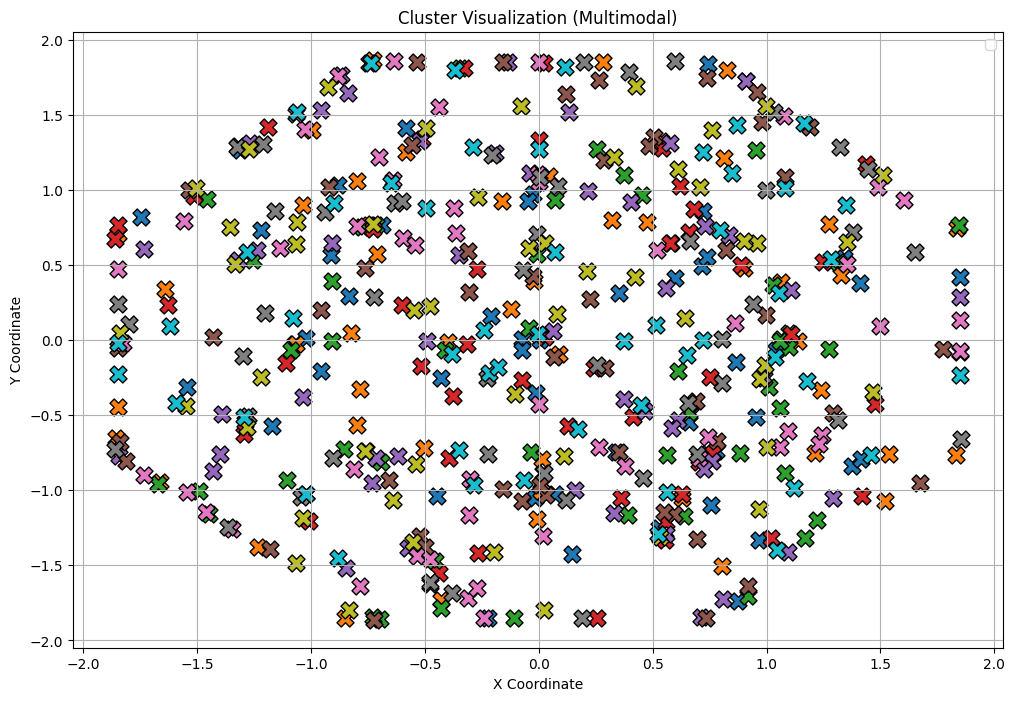

In [54]:
n_cluster = 500
with open("data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers",'rb') as file:
    cluster_data = pickle.load(file)
    
plot_clusters(cluster_data, labels_type='multimodal')

In [58]:
def evaluate_clusters(clustering_instance, labels_type='multimodal'):
    """
    Evaluate clusters spatially and angularly to extract meaningful insights.

    Parameters:
    - clustering_instance: An instance of ClusteringWithLabels containing cluster data.
    - labels_type: 'multimodal' or 'cnn', determines which labels to analyze.

    Returns:
    - metrics: A dictionary of metrics for each cluster.
    """
    # Extract data and labels
    labels = getattr(clustering_instance, f"{labels_type}_labels")
    xy_theta = np.hstack((
        np.array(clustering_instance.xy_list),
        np.array(clustering_instance.theta_list).reshape(-1, 1)
    ))

    metrics = {}
    for cluster in np.unique(labels):
        cluster_points = xy_theta[labels == cluster]
        x, y, theta = cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2]

        # Centroid
        centroid = (
            np.mean(x),
            np.mean(y),
            np.arctan2(np.mean(np.sin(theta)), np.mean(np.cos(theta)))
        )

        # Variance and Convex Hull Area
        variance = (np.var(x), np.var(y))
        convex_hull_area = ConvexHull(cluster_points[:, :2]).volume if len(cluster_points) > 2 else 0

        # Angular Dispersion
        R = np.sqrt(np.mean(np.cos(theta))**2 + np.mean(np.sin(theta))**2)
        angular_dispersion = 1 - R

        metrics[cluster] = {
            "centroid": centroid,
            "spatial_variance": variance,
            "convex_hull_area": convex_hull_area,
            "angular_dispersion": angular_dispersion
        }
    
    return metrics

def interpret_clusters(metrics):
    """
    Interpret clustering data and provide meaningful insights.

    Parameters:
    - metrics: A dictionary containing clustering metrics for each cluster,
               such as centroids, spatial variance, convex hull area, and angular dispersion.

    Returns:
    - insights: A list of human-readable insights for each cluster.
    """
    insights = []

    for cluster, cluster_metrics in metrics.items():
        centroid = cluster_metrics["centroid"]
        variance = cluster_metrics["spatial_variance"]
        convex_hull_area = cluster_metrics["convex_hull_area"]
        angular_dispersion = cluster_metrics["angular_dispersion"]

        # Generate spatial insights
        spatial_insight = (
            f"Cluster {cluster} is centered around (X: {centroid[0]:.2f}, Y: {centroid[1]:.2f}), "
            f"spanning an area of approximately {convex_hull_area:.2f} m². "
            f"The spatial spread (variance) is X: {variance[0]:.2f} and Y: {variance[1]:.2f}."
        )

        # Generate angular insights
        dominant_heading = np.degrees(centroid[2]) % 360  # Convert radians to degrees
        angular_insight = (
            f"The dominant heading is approximately {dominant_heading:.2f}° "
            f"with an angular dispersion of {angular_dispersion:.2f}."
        )

        # Combine insights
        insights.append(spatial_insight + " " + angular_insight)

    return insights


In [60]:
n_cluster = 500
with open("data/VisualPlaceCellData/ClustersWithLabels/Clusters"+str(n_cluster)+"centers",'rb') as file:
    cluster_data = pickle.load(file)
    
# Calculate Cluster Purity
cluster_metrics = evaluate_clusters(cluster_data, labels_type='multimodal')

insights = interpret_clusters(cluster_metrics)
for insight in insights:
    print(insight)

Cluster 0 is centered around (X: -0.43, Y: -0.25), spanning an area of approximately 1.20 m². The spatial spread (variance) is X: 0.34 and Y: 0.63. The dominant heading is approximately 42.26° with an angular dispersion of 0.42.
Cluster 1 is centered around (X: 0.72, Y: 0.49), spanning an area of approximately 0.34 m². The spatial spread (variance) is X: 0.01 and Y: 0.59. The dominant heading is approximately 233.24° with an angular dispersion of 0.00.
Cluster 2 is centered around (X: -0.91, Y: 0.57), spanning an area of approximately 0.01 m². The spatial spread (variance) is X: 0.00 and Y: 0.01. The dominant heading is approximately 174.93° with an angular dispersion of 0.00.
Cluster 3 is centered around (X: -0.58, Y: 1.41), spanning an area of approximately 1.39 m². The spatial spread (variance) is X: 0.15 and Y: 0.41. The dominant heading is approximately 48.17° with an angular dispersion of -0.00.
Cluster 4 is centered around (X: -1.75, Y: 0.82), spanning an area of approximately 0

In [ ]:
def compare_clustering_performance(clustering_instance, labels_types, num_place_cells_list):
    """
    Compare clustering performance across methods and configurations.

    Parameters:
    - clustering_instance: An instance of ClusteringWithLabels containing data.
    - labels_types: List of label types to compare (e.g., ['multimodal', 'cnn']).
    - num_place_cells_list: List of place cell configurations (e.g., [10, 20, 100]).

    Returns:
    - comparison_results: A dictionary of aggregated metrics for each configuration.
    """
    comparison_results = {}

    for labels_type in labels_types:
        for num_place_cells in num_place_cells_list:
            # Adjust data based on the number of place cells (if needed)
            clustering_instance.xy_list = clustering_instance.xy_list[:num_place_cells]
            clustering_instance.theta_list = clustering_instance.theta_list[:num_place_cells]
            
            # Evaluate clusters
            metrics = evaluate_clusters(clustering_instance, labels_type=labels_type)

            # Aggregate metrics
            avg_area = np.mean([m["convex_hull_area"] for m in metrics.values()])
            avg_variance = np.mean([
                (m["spatial_variance"][0] + m["spatial_variance"][1]) / 2 for m in metrics.values()
            ])
            avg_angular_dispersion = np.mean([m["angular_dispersion"] for m in metrics.values()])
            heading_std = np.std([m["centroid"][2] for m in metrics.values()])

            # Save results
            config_name = f"{labels_type}_place_cells_{num_place_cells}"
            comparison_results[config_name] = {
                "avg_area": avg_area,
                "avg_variance": avg_variance,
                "avg_angular_dispersion": avg_angular_dispersion,
                "heading_std": heading_std,
            }

    return comparison_results